In [1]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'5.3.0'

In [2]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
Created temporary directory: /tmp/pip-ephem-wheel-cache-xmuuaymh
Created temporary directory: /tmp/pip-req-tracker-kk5km7vk
Created requirements tracker '/tmp/pip-req-tracker-kk5km7vk'
Created temporary directory: /tmp/pip-install-1cgwussu
1 location(s) to search for versions of Pillow:
* https://pypi.org/simple/pillow/
Getting page https://pypi.org/simple/pillow/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/pillow/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/pillow/ HTTP/1.1" 200 168421
Updating cache with response from "https://pypi.org/simple/pillow/"
Caching due to etag
Analyzing links from page https://pypi.org/simple/pillow/
  Found link https://files.pythonhosted.org/packages/72/e6/692512c5d9dc97f83a91f8a75806e0b9e910ebd8d6b0b3d6ca9a249c1e26/Pillow-1.0.tar.gz#sha256=be8643522995b496

---


**ВНИМАНИЕ: На этом этапе обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.**

После перезапуска рантайма следует продолжить исполнять ячейки далее.

---



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [2]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)


In [0]:
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).




---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [0]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [6]:
!ls train

simpsons_dataset


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon May 18 10:21:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
#RESCALE_SIZE = 299 #для inception
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
import random
import os
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])
        transform_aug = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(30),
                        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
            x = transform(x)
            return x
        else:
            if self.mode == 'val':
                x = transform(x)
            else:
                x = transform_aug(x)

            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

**OVERSAMPLING**

In [0]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [0]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [0]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [18]:
# Посмотрим, что у нас получилось.
print_dct(dct_path_train)

abraham_grampa_simpson	[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0429.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0903.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0172.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0487.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0722.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0749.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0822.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0079.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0063.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0359.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0030.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0687.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0825.jpg'), PosixPath('train/simpsons_d

In [0]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [20]:
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [0]:
new_train_files = []
for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [0]:
#uncomment if you have problem with pillow
#def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
#Image.register_extension = register_extension
#def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
#Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

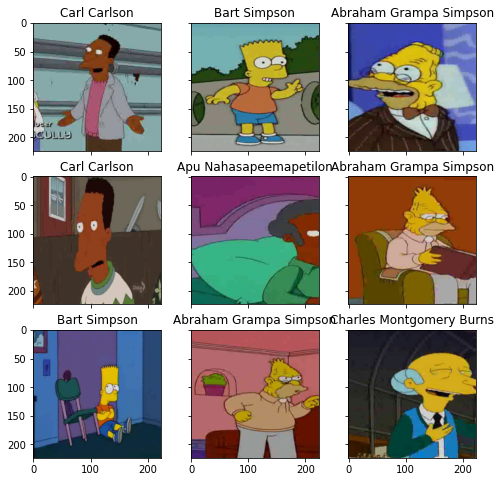

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети ### 



In [0]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

class ModelCnn(nn.Module):
  
    def __init__(self, n_classes):
        
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(6 * 6 * 128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, n_classes)
        )  

  
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        

        x = F.interpolate(x, size=(6, 6), mode='bilinear')  # resize to the size expected by the linear unit
        x = x.view(x.size(0), 6 * 6 * 128)
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        x = self.fc4(x)
        
        return x

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)



        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    #dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            


            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_loss)
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

**Обучение своей и resnet152 модели**

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [0]:
n_classes = len(np.unique(train_val_labels))
model_cnn = ModelCnn(n_classes).to(DEVICE)

In [32]:
history = train(train_dataset, val_dataset, model=model_cnn, epochs=25, batch_size=128)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


loss 2.5994261360620032


epoch:   4%|▍         | 1/25 [04:29<1:47:40, 269.20s/it]


Epoch 001 train_loss: 2.5994     val_loss 2.3294 train_acc 0.2953 val_acc 0.3771
loss 2.7790298952863006


epoch:   8%|▊         | 2/25 [09:02<1:43:42, 270.55s/it]


Epoch 002 train_loss: 2.7790     val_loss 1.9214 train_acc 0.2561 val_acc 0.4616
loss 2.0290040315979154


epoch:  12%|█▏        | 3/25 [13:36<1:39:33, 271.53s/it]


Epoch 003 train_loss: 2.0290     val_loss 1.4428 train_acc 0.4355 val_acc 0.5755
loss 1.6317126024259763


epoch:  16%|█▌        | 4/25 [18:09<1:35:08, 271.82s/it]


Epoch 004 train_loss: 1.6317     val_loss 1.1998 train_acc 0.5365 val_acc 0.6563
loss 1.3589014391392495


epoch:  20%|██        | 5/25 [22:35<1:30:03, 270.16s/it]


Epoch 005 train_loss: 1.3589     val_loss 0.9437 train_acc 0.6110 val_acc 0.7350
loss 1.1781702433792436


epoch:  24%|██▍       | 6/25 [27:01<1:25:09, 268.92s/it]


Epoch 006 train_loss: 1.1782     val_loss 0.8739 train_acc 0.6613 val_acc 0.7432
loss 0.9974656217724094


epoch:  28%|██▊       | 7/25 [31:26<1:20:20, 267.80s/it]


Epoch 007 train_loss: 0.9975     val_loss 0.8219 train_acc 0.7180 val_acc 0.7650
loss 0.8967370654323744


epoch:  32%|███▏      | 8/25 [35:51<1:15:38, 266.98s/it]


Epoch 008 train_loss: 0.8967     val_loss 0.6962 train_acc 0.7413 val_acc 0.8019
loss 0.7709945194853167


epoch:  36%|███▌      | 9/25 [40:16<1:11:02, 266.40s/it]


Epoch 009 train_loss: 0.7710     val_loss 0.6684 train_acc 0.7770 val_acc 0.8139
loss 0.6815184595599687


epoch:  40%|████      | 10/25 [44:41<1:06:26, 265.76s/it]


Epoch 010 train_loss: 0.6815     val_loss 0.6455 train_acc 0.8003 val_acc 0.8212
loss 0.6397569803487412


epoch:  44%|████▍     | 11/25 [49:05<1:01:56, 265.46s/it]


Epoch 011 train_loss: 0.6398     val_loss 0.6136 train_acc 0.8118 val_acc 0.8374
loss 0.5674604484300424


epoch:  48%|████▊     | 12/25 [53:30<57:29, 265.36s/it]


Epoch 012 train_loss: 0.5675     val_loss 0.5865 train_acc 0.8346 val_acc 0.8399
loss 0.5493584318357164


epoch:  52%|█████▏    | 13/25 [57:58<53:13, 266.15s/it]


Epoch 013 train_loss: 0.5494     val_loss 0.5557 train_acc 0.8380 val_acc 0.8498
loss 0.47937533181953373


epoch:  56%|█████▌    | 14/25 [1:02:25<48:48, 266.24s/it]


Epoch 014 train_loss: 0.4794     val_loss 0.6358 train_acc 0.8623 val_acc 0.8319
loss 0.45425690584861517


epoch:  60%|██████    | 15/25 [1:06:50<44:17, 265.75s/it]


Epoch 015 train_loss: 0.4543     val_loss 0.5916 train_acc 0.8646 val_acc 0.8500
loss 0.4080114509834274


epoch:  64%|██████▍   | 16/25 [1:11:14<39:49, 265.51s/it]


Epoch 016 train_loss: 0.4080     val_loss 0.5186 train_acc 0.8793 val_acc 0.8710
loss 0.40028569810610615


epoch:  68%|██████▊   | 17/25 [1:15:39<35:22, 265.31s/it]


Epoch 017 train_loss: 0.4003     val_loss 0.5549 train_acc 0.8812 val_acc 0.8559
loss 0.37261012760482976


epoch:  72%|███████▏  | 18/25 [1:20:04<30:55, 265.12s/it]


Epoch 018 train_loss: 0.3726     val_loss 0.5005 train_acc 0.8900 val_acc 0.8672
loss 0.35047780903407405


epoch:  76%|███████▌  | 19/25 [1:24:29<26:30, 265.04s/it]


Epoch 019 train_loss: 0.3505     val_loss 0.5279 train_acc 0.8944 val_acc 0.8745
loss 0.3465547469883637


epoch:  80%|████████  | 20/25 [1:28:54<22:04, 264.95s/it]


Epoch 020 train_loss: 0.3466     val_loss 0.5332 train_acc 0.8949 val_acc 0.8695
loss 0.3033125980555147


epoch:  84%|████████▍ | 21/25 [1:33:19<17:40, 265.09s/it]


Epoch 021 train_loss: 0.3033     val_loss 0.5226 train_acc 0.9115 val_acc 0.8773
loss 0.326075458154413


epoch:  88%|████████▊ | 22/25 [1:37:45<13:15, 265.24s/it]


Epoch 022 train_loss: 0.3261     val_loss 0.4921 train_acc 0.9020 val_acc 0.8842
loss 0.2915027513187219


epoch:  92%|█████████▏| 23/25 [1:42:10<08:50, 265.16s/it]


Epoch 023 train_loss: 0.2915     val_loss 0.5412 train_acc 0.9136 val_acc 0.8814
loss 0.2685894222090533


epoch:  96%|█████████▌| 24/25 [1:46:35<04:25, 265.09s/it]


Epoch 024 train_loss: 0.2686     val_loss 0.5648 train_acc 0.9198 val_acc 0.8741
loss 0.26990149614196374


epoch: 100%|██████████| 25/25 [1:50:58<00:00, 266.36s/it]


Epoch 025 train_loss: 0.2699     val_loss 0.5585 train_acc 0.9216 val_acc 0.8812


In [0]:
torch.save(model_cnn.state_dict(), 'gdrive/My Drive/model_cnn_final.pth') 

In [0]:
import torchvision.models as models
model_resnet152 = models.resnet152(pretrained=True).to(DEVICE)

for name, child in model_resnet152.named_children():
   if name in ['fc', 'avgpool', 'layer4']:
       for param in child.parameters():
           param.requires_grad = True
   else:
       for param in child.parameters():
           param.requires_grad = False

model_resnet152.fc = nn.Linear(2048, n_classes).cuda()

In [38]:
history = train(train_dataset, val_dataset, model=model_resnet152, epochs=25, batch_size=128)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.9293517329277249


epoch:   4%|▍         | 1/25 [08:09<3:15:38, 489.11s/it]


Epoch 001 train_loss: 0.9294     val_loss 0.3947 train_acc 0.7669 val_acc 0.8957
loss 3.9269043785116664


epoch:   8%|▊         | 2/25 [16:05<3:05:59, 485.19s/it]


Epoch 002 train_loss: 3.9269     val_loss 2.6606 train_acc 0.1286 val_acc 0.2614
loss 2.046492440293406


epoch:  12%|█▏        | 3/25 [24:01<2:56:53, 482.45s/it]


Epoch 003 train_loss: 2.0465     val_loss 0.9864 train_acc 0.4615 val_acc 0.7411
loss 1.0152002997672145


epoch:  16%|█▌        | 4/25 [31:56<2:48:08, 480.41s/it]


Epoch 004 train_loss: 1.0152     val_loss 0.5471 train_acc 0.7251 val_acc 0.8561
loss 0.703123151924385


epoch:  20%|██        | 5/25 [39:53<2:39:42, 479.14s/it]


Epoch 005 train_loss: 0.7031     val_loss 0.5322 train_acc 0.8024 val_acc 0.8579
loss 0.5774208572532482


epoch:  24%|██▍       | 6/25 [47:48<2:31:24, 478.11s/it]


Epoch 006 train_loss: 0.5774     val_loss 0.4067 train_acc 0.8438 val_acc 0.8877
loss 0.4649843839841963


epoch:  28%|██▊       | 7/25 [55:44<2:23:13, 477.42s/it]


Epoch 007 train_loss: 0.4650     val_loss 0.3248 train_acc 0.8701 val_acc 0.9113
loss 0.435269633522045


epoch:  32%|███▏      | 8/25 [1:03:41<2:15:11, 477.16s/it]


Epoch 008 train_loss: 0.4353     val_loss 0.3014 train_acc 0.8791 val_acc 0.9198
loss 0.35241695935643613


epoch:  36%|███▌      | 9/25 [1:11:39<2:07:20, 477.51s/it]


Epoch 009 train_loss: 0.3524     val_loss 0.2909 train_acc 0.9013 val_acc 0.9196
loss 0.3109378455658219


epoch:  40%|████      | 10/25 [1:19:36<1:59:20, 477.37s/it]


Epoch 010 train_loss: 0.3109     val_loss 0.2920 train_acc 0.9112 val_acc 0.9224
loss 0.28921129587805106


epoch:  44%|████▍     | 11/25 [1:27:32<1:51:18, 477.07s/it]


Epoch 011 train_loss: 0.2892     val_loss 0.2742 train_acc 0.9184 val_acc 0.9236
loss 0.2697000873903792


epoch:  48%|████▊     | 12/25 [1:35:29<1:43:21, 477.01s/it]


Epoch 012 train_loss: 0.2697     val_loss 0.2971 train_acc 0.9244 val_acc 0.9259
loss 0.26232048367635497


epoch:  52%|█████▏    | 13/25 [1:43:26<1:35:22, 476.87s/it]


Epoch 013 train_loss: 0.2623     val_loss 0.2585 train_acc 0.9284 val_acc 0.9322
loss 0.25394103306219684


epoch:  56%|█████▌    | 14/25 [1:51:22<1:27:25, 476.82s/it]


Epoch 014 train_loss: 0.2539     val_loss 0.2336 train_acc 0.9274 val_acc 0.9404
loss 0.21416219258386027


epoch:  60%|██████    | 15/25 [1:59:19<1:19:28, 476.87s/it]


Epoch 015 train_loss: 0.2142     val_loss 0.2295 train_acc 0.9409 val_acc 0.9415
loss 0.21482489036363622


epoch:  64%|██████▍   | 16/25 [2:07:13<1:11:22, 475.80s/it]


Epoch 016 train_loss: 0.2148     val_loss 0.2000 train_acc 0.9389 val_acc 0.9532
loss 0.19836336336357419


epoch:  68%|██████▊   | 17/25 [2:15:06<1:03:20, 475.05s/it]


Epoch 017 train_loss: 0.1984     val_loss 0.1884 train_acc 0.9422 val_acc 0.9534
loss 0.1946705873106386


epoch:  72%|███████▏  | 18/25 [2:23:00<55:22, 474.68s/it]


Epoch 018 train_loss: 0.1947     val_loss 0.2051 train_acc 0.9456 val_acc 0.9484
loss 0.17168471291242318


epoch:  76%|███████▌  | 19/25 [2:30:54<47:27, 474.63s/it]


Epoch 019 train_loss: 0.1717     val_loss 0.2250 train_acc 0.9518 val_acc 0.9492
loss 0.18173122411033182


epoch:  80%|████████  | 20/25 [2:38:50<39:34, 474.93s/it]


Epoch 020 train_loss: 0.1817     val_loss 0.2022 train_acc 0.9488 val_acc 0.9486
loss 0.1590943311253184


epoch:  84%|████████▍ | 21/25 [2:46:45<31:39, 474.87s/it]


Epoch 021 train_loss: 0.1591     val_loss 0.2003 train_acc 0.9557 val_acc 0.9498
loss 0.16330403875637844


epoch:  88%|████████▊ | 22/25 [2:54:40<23:44, 474.91s/it]


Epoch 022 train_loss: 0.1633     val_loss 0.2122 train_acc 0.9535 val_acc 0.9496
loss 0.15808729801209023


epoch:  92%|█████████▏| 23/25 [3:02:35<15:49, 474.88s/it]


Epoch 023 train_loss: 0.1581     val_loss 0.2114 train_acc 0.9537 val_acc 0.9498
loss 0.13723868563149447


epoch:  96%|█████████▌| 24/25 [3:10:30<07:55, 475.12s/it]


Epoch 024 train_loss: 0.1372     val_loss 0.2126 train_acc 0.9594 val_acc 0.9501
loss 0.14685360677022136


epoch: 100%|██████████| 25/25 [3:18:29<00:00, 476.36s/it]


Epoch 025 train_loss: 0.1469     val_loss 0.1960 train_acc 0.9584 val_acc 0.9536


In [0]:
torch.save(model_resnet152.state_dict(), 'gdrive/My Drive/model_resnet152_final.pth') 

Создание ансамбля

In [0]:
class Ensemble(nn.Module):   
    def __init__(self, modelA, modelB, classes_number):
        super(Ensemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(classes_number * 2, classes_number)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(x)
        return x

In [0]:
model_ensemble = Ensemble(model_resnet152, model_cnn, n_classes).cuda()

In [0]:
for param in model_ensemble.parameters():
    param.requires_grad = False

for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

Запустим обучение сети.

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
#train_dataset = SimpsonsDataset(train_files, mode='train')
train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [44]:
history = train(train_dataset, val_dataset, model=model_ensemble.cuda(), epochs=30, batch_size=128)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


loss 1.516535644035221


epoch:   3%|▎         | 1/30 [07:43<3:44:13, 463.90s/it]


Epoch 001 train_loss: 1.5165     val_loss 0.2846 train_acc 0.7162 val_acc 0.9308
loss 0.2085024832462058


epoch:   7%|▋         | 2/30 [15:24<3:35:59, 462.84s/it]


Epoch 002 train_loss: 0.2085     val_loss 0.2100 train_acc 0.9572 val_acc 0.9494
loss 0.14556659371472208


epoch:  10%|█         | 3/30 [23:03<3:27:46, 461.73s/it]


Epoch 003 train_loss: 0.1456     val_loss 0.1848 train_acc 0.9693 val_acc 0.9549
loss 0.11440880105415369


epoch:  13%|█▎        | 4/30 [30:43<3:19:49, 461.13s/it]


Epoch 004 train_loss: 0.1144     val_loss 0.1727 train_acc 0.9770 val_acc 0.9576
loss 0.1006000891782081


epoch:  17%|█▋        | 5/30 [38:24<3:12:12, 461.31s/it]


Epoch 005 train_loss: 0.1006     val_loss 0.1650 train_acc 0.9798 val_acc 0.9599
loss 0.08951773174806049


epoch:  20%|██        | 6/30 [46:07<3:04:40, 461.68s/it]


Epoch 006 train_loss: 0.0895     val_loss 0.1597 train_acc 0.9823 val_acc 0.9612
loss 0.08370809528020826


epoch:  23%|██▎       | 7/30 [53:50<2:57:09, 462.15s/it]


Epoch 007 train_loss: 0.0837     val_loss 0.1595 train_acc 0.9803 val_acc 0.9614
loss 0.07703948101328124


epoch:  27%|██▋       | 8/30 [1:01:34<2:49:39, 462.70s/it]


Epoch 008 train_loss: 0.0770     val_loss 0.1549 train_acc 0.9830 val_acc 0.9635
loss 0.07382801816498044


epoch:  30%|███       | 9/30 [1:09:19<2:42:12, 463.45s/it]


Epoch 009 train_loss: 0.0738     val_loss 0.1547 train_acc 0.9830 val_acc 0.9633
loss 0.06941645911167926


epoch:  33%|███▎      | 10/30 [1:17:03<2:34:31, 463.59s/it]


Epoch 010 train_loss: 0.0694     val_loss 0.1545 train_acc 0.9841 val_acc 0.9641
loss 0.06524973470639392


epoch:  37%|███▋      | 11/30 [1:24:44<2:26:34, 462.85s/it]


Epoch 011 train_loss: 0.0652     val_loss 0.1542 train_acc 0.9850 val_acc 0.9650
loss 0.06513499520866783


epoch:  40%|████      | 12/30 [1:32:25<2:18:41, 462.29s/it]


Epoch 012 train_loss: 0.0651     val_loss 0.1543 train_acc 0.9850 val_acc 0.9622
loss 0.06282349009905809


epoch:  43%|████▎     | 13/30 [1:40:07<2:10:54, 462.02s/it]


Epoch 013 train_loss: 0.0628     val_loss 0.1518 train_acc 0.9859 val_acc 0.9643
loss 0.06144581177057194


epoch:  47%|████▋     | 14/30 [1:47:54<2:03:35, 463.45s/it]


Epoch 014 train_loss: 0.0614     val_loss 0.1528 train_acc 0.9851 val_acc 0.9658
loss 0.06057112183588325


epoch:  50%|█████     | 15/30 [1:55:44<1:56:21, 465.46s/it]


Epoch 015 train_loss: 0.0606     val_loss 0.1512 train_acc 0.9855 val_acc 0.9660
loss 0.05975163889710951


epoch:  53%|█████▎    | 16/30 [2:03:32<1:48:49, 466.42s/it]


Epoch 016 train_loss: 0.0598     val_loss 0.1538 train_acc 0.9863 val_acc 0.9664
loss 0.056582943994588276


epoch:  57%|█████▋    | 17/30 [2:11:22<1:41:15, 467.36s/it]


Epoch 017 train_loss: 0.0566     val_loss 0.1526 train_acc 0.9860 val_acc 0.9668
loss 0.056822572001808666


epoch:  60%|██████    | 18/30 [2:19:12<1:33:38, 468.23s/it]


Epoch 018 train_loss: 0.0568     val_loss 0.1550 train_acc 0.9860 val_acc 0.9650
loss 0.05148321782591852


epoch:  63%|██████▎   | 19/30 [2:27:03<1:25:58, 468.99s/it]


Epoch 019 train_loss: 0.0515     val_loss 0.1539 train_acc 0.9876 val_acc 0.9648
loss 0.0514694424256237


epoch:  67%|██████▋   | 20/30 [2:34:55<1:18:19, 469.95s/it]


Epoch 020 train_loss: 0.0515     val_loss 0.1541 train_acc 0.9873 val_acc 0.9656
loss 0.052450862906974656


epoch:  70%|███████   | 21/30 [2:42:50<1:10:43, 471.45s/it]


Epoch 021 train_loss: 0.0525     val_loss 0.1525 train_acc 0.9870 val_acc 0.9671
loss 0.051368378457999436


epoch:  73%|███████▎  | 22/30 [2:50:43<1:02:54, 471.81s/it]


Epoch 022 train_loss: 0.0514     val_loss 0.1542 train_acc 0.9880 val_acc 0.9652
loss 0.05091487660355806


epoch:  77%|███████▋  | 23/30 [2:58:35<55:03, 471.88s/it]


Epoch 023 train_loss: 0.0509     val_loss 0.1552 train_acc 0.9874 val_acc 0.9654
loss 0.051083748024502745


epoch:  80%|████████  | 24/30 [3:06:28<47:12, 472.15s/it]


Epoch 024 train_loss: 0.0511     val_loss 0.1593 train_acc 0.9863 val_acc 0.9643
loss 0.04872221752326494


epoch:  83%|████████▎ | 25/30 [3:14:26<39:29, 473.90s/it]


Epoch 025 train_loss: 0.0487     val_loss 0.1581 train_acc 0.9889 val_acc 0.9643
loss 0.04747443527366925


epoch:  87%|████████▋ | 26/30 [3:22:21<31:37, 474.32s/it]


Epoch 026 train_loss: 0.0475     val_loss 0.1537 train_acc 0.9883 val_acc 0.9656
loss 0.04571821467874317


epoch:  90%|█████████ | 27/30 [3:30:15<23:43, 474.36s/it]


Epoch 027 train_loss: 0.0457     val_loss 0.1531 train_acc 0.9893 val_acc 0.9664
loss 0.044918088577676714


epoch:  93%|█████████▎| 28/30 [3:38:11<15:49, 474.75s/it]


Epoch 028 train_loss: 0.0449     val_loss 0.1538 train_acc 0.9892 val_acc 0.9664
loss 0.046164181055658206


epoch:  97%|█████████▋| 29/30 [3:46:07<07:55, 475.24s/it]


Epoch 029 train_loss: 0.0462     val_loss 0.1535 train_acc 0.9894 val_acc 0.9668
loss 0.046806327083356705


epoch: 100%|██████████| 30/30 [3:54:03<00:00, 468.12s/it]


Epoch 030 train_loss: 0.0468     val_loss 0.1533 train_acc 0.9888 val_acc 0.9668


In [0]:
torch.save(model_ensemble.state_dict(), 'gdrive/My Drive/ensemble_of_custom_resnet152_final.pth') 

Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

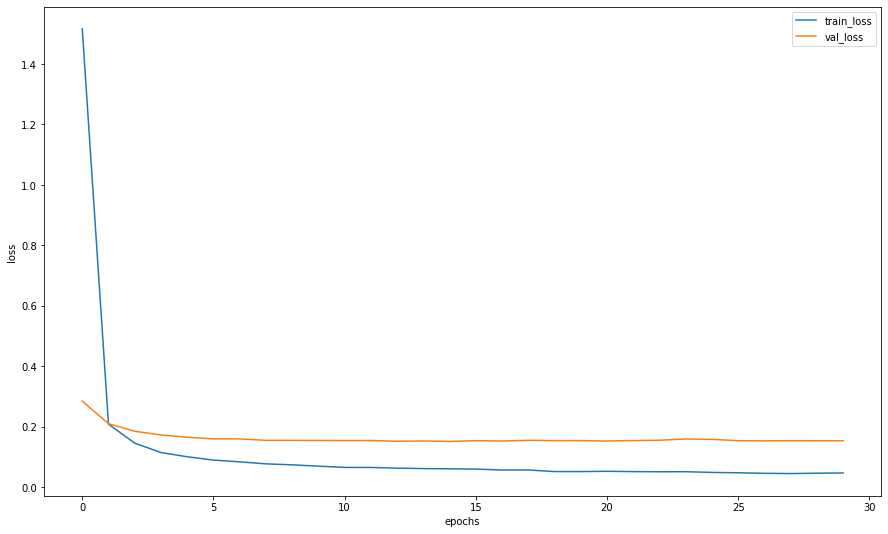

In [47]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

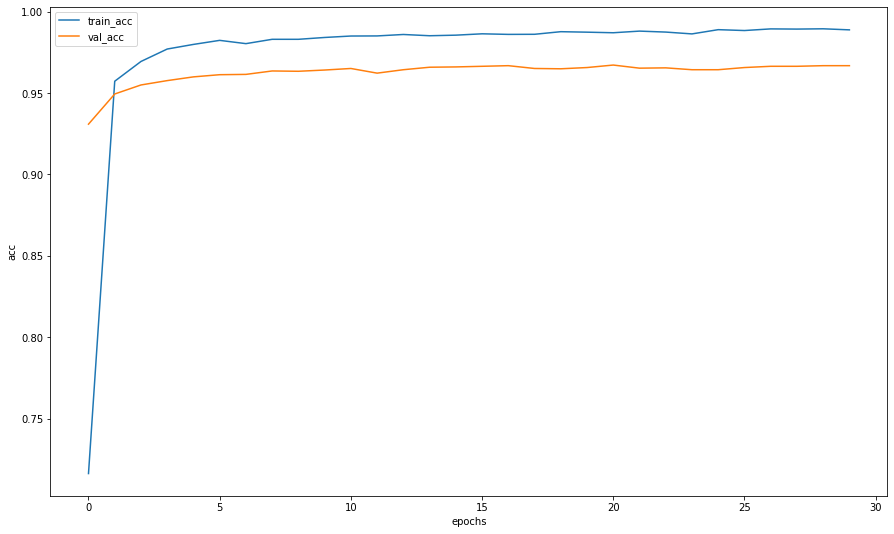

In [48]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [50]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_ensemble, ex_img.unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [51]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_ensemble, imgs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [54]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


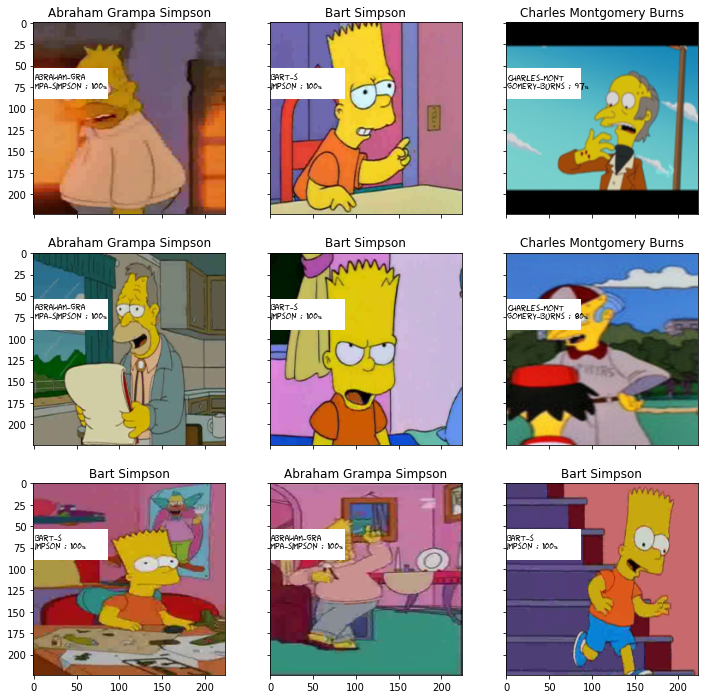

In [55]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ensemble, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [56]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model_ensemble, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:

import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_ensemble.csv', index=False)
# файл появится у вас на гугл диске